# LAMMPS Data Processing

In [23]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

In [24]:
def D_func(slope):
    # Slope in A2 /ps
    # Output in     cm2/s
    return (slope / 6) * 10**12 / (10**(8*2))

def N_eff_func(ave_msd, a):
    return max(ave_msd) * 420 / (a**2)

def sigma_func(D, N_mobile_ions, unit_cell_volume, T):
    return ( (D * (10**-2)**2) * (N_mobile_ions/(unit_cell_volume*(10**-10)**3)) * ((1.6e-19)**2) / (1.38e-23*T) ) * (10**3/10**2)

def E_a_func(slope):
    return -slope*(8.62*10**-5)*np.log(10)

In [25]:
a = 2.4 # Approx. site hopping length, for use in N_Eff
record_freq = 10
diffusivity_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration', 'Temperature (K)', 'Run Number', 
           'Diffusivity (cm^2/s)', 'Conductivity (mS/cm)', 'Correlation Factor',  'N Eff (>500)']
diffusivity_df = pd.DataFrame(columns=diffusivity_columns)
for element in ['Al']:
    for concentration in np.arange(0, 0.75, 0.05):
        for (T, unit_cell_volume, dt) in [(300, 25.98808**3, 0.004), (600, 26.08711**3, 0.004), (900, 26.18614**3, 0.001), (1200, 26.28517**3, 0.001), (1500, 26.38420**3, 0.001)]:
            for config in [0, 1, 2]:

                linearModel = LinearRegression()

                # MSD / MSCD
                for i,msd_file in enumerate(glob.glob('data/LLZO_Ia3d_%s%02.f_%.0f/msd*-%.0f.out' % (element, 100*concentration, config, T))):
                    df = pd.read_csv(msd_file, sep=" ", low_memory=False)
                    pos = np.array(df['Time-averaged'])
                    msd = pos[6::5].astype('float64')
                    time = dt*record_freq*np.array(range(msd.shape[0]))
                    if len(time) < 2*int(10/(dt*record_freq)):
                        print(r'%0.2f %d' % (concentration, T))
                        continue

                    linearModel.fit(time[int(10/(dt*record_freq)):].reshape(-1,1), msd[int(10/(dt*record_freq)):])
                    D = D_func(linearModel.coef_[0])

                    N_eff = N_eff_func(msd, a)

                    mscd_file = 'data/LLZO_Ia3d_%s%02.f_%.0f/mscd%.0f-%.0f.out' % (element, 100*concentration, config, i, T)
                    try:
                        df = pd.read_csv(mscd_file, sep=" ", low_memory=False)
                        pos = np.array(df['Time-averaged'])
                        mscd = pos[6::5].astype('float64')

                        time = dt*record_freq*np.array(range(mscd.shape[0]))
                        linearModel.fit(time[int(10/(dt*record_freq)):].reshape(-1,1), mscd[int(10/(dt*record_freq)):])
                        Dj = D_func(linearModel.coef_[0])
                    except FileNotFoundError:
                        Dj = np.nan
                
                    # Sigma
                    N_mobile_ions = 448 - 1200*concentration/5
                    sigma = sigma_func(D, N_mobile_ions, unit_cell_volume, T)
                    
                    # Correlation factor
                    corr = D/Dj if T!=300 else np.NAN

                    # Put into total dataframe
                    entry = pd.DataFrame([[element, concentration, config, T, i, D, sigma, corr, N_eff]], columns=diffusivity_columns)
                    diffusivity_df = pd.concat([diffusivity_df, entry], ignore_index=True)

0.05 900
0.20 900
0.30 900
0.30 900
0.65 900
0.70 900


,Doping Element,Doping Concentration (Formulaic),Activation Energy (eV),RT D (cm2/s),Average Correlation
0,Al,0.00,0.264615,4.922193e-07,3.015609
1,Al,0.05,0.259795,5.526109e-07,3.041821
2,Al,0.10,0.247462,8.034614e-07,3.034171
3,Al,0.15,0.270872,3.401879e-07,3.020418
4,Al,0.20,0.275482,2.808189e-07,3.059680
5,Al,0.25,0.279562,2.307017e-07,3.025594
6,Al,0.30,0.301634,1.044505e-07,3.093433
7,Al,0.35,0.337219,2.811907e-08,3.187825
8,Al,0.40,0.329856,3.421623e-08,3.089571
9,Al,0.45,0.356013,1.423274e-08,3.193769


,Doping Element,Doping Concentration (Formulaic),Activation Energy (eV),RT D (cm2/s),Average Correlation
0,Al,0.00,0.264615,4.922193e-07,3.015609
1,Al,0.05,0.258689,5.669008e-07,2.996459
2,Al,0.05,0.276386,3.101827e-07,3.052311
3,Al,0.05,0.260316,5.536994e-07,3.103436
4,Al,0.10,0.242150,9.621178e-07,3.026144
5,Al,0.10,0.261555,4.953173e-07,3.078380
6,Al,0.10,0.272924,3.307888e-07,2.998416
7,Al,0.15,0.265984,4.006700e-07,2.897505
8,Al,0.15,0.285334,2.057620e-07,3.093769
9,Al,0.15,0.275752,2.871887e-07,3.073650


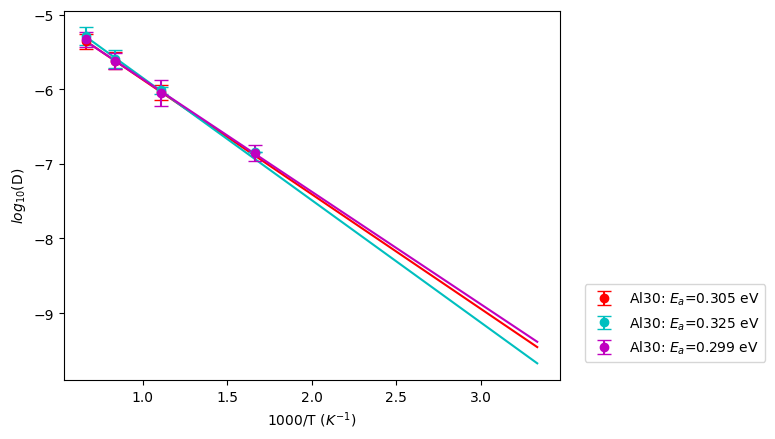

In [26]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

arrhenius_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 
           'Activation Energy (eV)', 'RT D (cm2/s)', 'Average Correlation']
arrhenius_df = pd.DataFrame(columns=arrhenius_columns)

arrhenius_config_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration',
           'Activation Energy (eV)', 'RT D (cm2/s)', 'Average Correlation']
arrhenius_config_df = pd.DataFrame(columns=arrhenius_columns)

# Arrenhius method
def arrhenius(dataframe, plot=False):
    T_groups = dataframe.groupby(['Temperature (K)']).groups
    D_mean = []
    D_std = []
    T = []
    for T_key in T_groups:
        T_group = T_groups[T_key]
        T_group_diffusivity = dataframe.iloc[T_group].reset_index()

        DT_mean = np.mean(T_group_diffusivity['Diffusivity (cm^2/s)'])
        DT_std = np.std(T_group_diffusivity['Diffusivity (cm^2/s)'])
        D_mean.append(DT_mean)
        D_std.append(DT_std)
        T.append(T_key)
    
    D_mean = np.array(D_mean)
    D_std = np.array(D_std)
    T = np.array(T)

    # Don't fit to 300K
    filter = T!=300
    T = T[filter]
    D_mean = D_mean[filter]
    D_std = D_std[filter]
    corr_mean = np.mean(dataframe['Correlation Factor'])

    x = 1./T
    y = np.log10(D_mean.astype('float32'))
    weights = D_std / D_mean

    model = LinearRegression()
    model.fit(x.reshape(-1,1), y, weights)
    E_a = E_a_func(model.coef_[0])
    
    D_0 = np.exp(model.intercept_)
    D_RT = D_0 * np.exp(-E_a / (8.62*10**-5 * 298))
    x_prime = np.linspace(np.min(x), 1/300, 100).reshape(-1,1)

    if plot:
        plt.errorbar(1000*x, y, yerr=weights, fmt='o', capsize=5, 
                    label=r'%s%02.f: $E_a$=%.3f eV' % (key[0], 100*key[1], E_a), c=colors[i%(len(colors)-1)])
        plt.plot(1000*x_prime, model.predict(x_prime), c=colors[i%(len(colors)-1)])

    entry = pd.DataFrame([[key[0], key[1], E_a, D_RT, corr_mean]], columns=arrhenius_columns)
    return entry

# Arrhenius without configuration information
groups = diffusivity_df.groupby(['Doping Element', 'Doping Concentration (Formulaic)']).groups
for i,key in enumerate(groups):
    group = groups[key]
    group_diffusivity = diffusivity_df.iloc[group].reset_index()
    
    entry = arrhenius(group_diffusivity)
    arrhenius_df = pd.concat([arrhenius_df, entry], ignore_index=True)
display(arrhenius_df)

# Arrhenius WITH configuration information
groups = diffusivity_df.groupby(['Doping Element', 'Doping Concentration (Formulaic)', 'Configuration']).groups
for i,key in enumerate(groups):
    group = groups[key]
    group_diffusivity = diffusivity_df.iloc[group].reset_index()
    plot = True if (i==18 or i==17 or i==16) else False
    entry = arrhenius(group_diffusivity, plot)
    arrhenius_config_df = pd.concat([arrhenius_config_df, entry], ignore_index=True)
display(arrhenius_config_df)

plt.legend(loc=(1.05, 0.05))
plt.xlabel(r'1000/T ($K^{-1}$)')
plt.ylabel(r'$log_{10}$(D)')
plt.show()

# # Experimental Data
# exp_diffusivity = pd.DataFrame([['Al', 0, None, 291, None, 0.337, None, None, None, None, None],
#                                 ['Al', 0, None, 298, None, 0.467, None, None, None, None, None], 
#                                 ['Al', 0, None, 323, None, 1.190, None, None, None, None, None], 
#                                ], columns=columns) 
# x = 1000./exp_diffusivity['Temperature (K)']
# y = np.log10(exp_diffusivity['Conductivity (mS/cm)'] * exp_diffusivity['Temperature (K)'])
# plt.scatter(x, y,
#             label=r'%s: $E_a$=%.3f eV, DOI: 10.1002/anie.200701144' % ('Exp Al00', 0.30),
#             marker = 'x'
#            )

# exp_diffusivity = pd.DataFrame([['Al', 0.2, None, 1000/2.68, None, 3.533, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/2.88, None, 1.735, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.10, None, 0.751, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.36, None, 0.293, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.67, None, 0.084, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.80, None, 0.045, None, None, None, None, None],
#                                 ['Al', 0.2, None, 1000/3.95, None, 0.024, None, None, None, None, None],
#                                ], columns=columns) 
# x = 1000./exp_diffusivity['Temperature (K)']
# y = np.log10(exp_diffusivity['Conductivity (mS/cm)'] * exp_diffusivity['Temperature (K)'])
# plt.scatter(x, y,
#             label=r'%s: $E_a$=%.3f eV,  DOI: 10.1038/srep18053' % ('Exp Al20', 0.36),
#             marker = 'x'
#            )

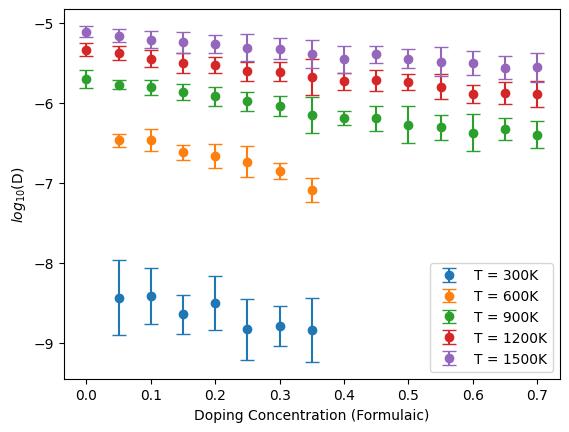

In [27]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

conc_summary_columns = ['Doping Concentration (Formulaic)', 'Temperature (K)', 
                        'Mean Diffusivity (cm^2/s)', 'STD Diffusivity (cm^2/s)']
conc_summary = pd.DataFrame(columns=conc_summary_columns)

diffusivity_df = diffusivity_df.reset_index()
groups = diffusivity_df.groupby(['Temperature (K)']).groups
for i,key in enumerate(groups):
    group = groups[key]
    group_diffusivity = diffusivity_df.iloc[group].reset_index()
    group_diffusivity = group_diffusivity.drop(columns=['level_0'])

    conc_groups = group_diffusivity.groupby(['Doping Concentration (Formulaic)']).groups
    for conc_i,conc_key in enumerate(conc_groups):
        conc_group = conc_groups[conc_key]
        conc_group_diffusivity = group_diffusivity.iloc[conc_group].reset_index()

        entry = pd.DataFrame([[conc_key, key, np.mean(conc_group_diffusivity['Diffusivity (cm^2/s)']), np.std(conc_group_diffusivity['Diffusivity (cm^2/s)'])]], columns=conc_summary_columns)
        conc_summary = pd.concat([conc_summary, entry], ignore_index=True)

groups = conc_summary.groupby(['Temperature (K)']).groups
for i,key in enumerate(groups):
    group = groups[key]
    data = conc_summary.iloc[group].reset_index()

    x = data['Doping Concentration (Formulaic)']
    y = np.log10(data['Mean Diffusivity (cm^2/s)']).astype('float32')
    weights = data['STD Diffusivity (cm^2/s)'] / data['Mean Diffusivity (cm^2/s)']

    plt.errorbar(x, y, yerr=weights, fmt='o', capsize=5, label=r'T = %0.fK' % (key))

plt.legend()
plt.xlabel("Doping Concentration (Formulaic)")
plt.ylabel(r'$log_{10}$(D)')
plt.show()

,Doping Element,Doping Concentration (Formulaic),Mean Activation Energy (eV),STD Activation Energy (eV),Mean RT D (cm2/s),STD RT D (cm2/s),Average Correlation
0,Al,0.00,0.264615,0.000000,4.922193e-07,0.000000e+00,3.015609
1,Al,0.05,0.265130,0.007987,4.769276e-07,1.180296e-07,3.050735
2,Al,0.10,0.258877,0.012705,5.960746e-07,2.674050e-07,3.034314
3,Al,0.15,0.275690,0.007899,2.978736e-07,7.992873e-08,3.021642
4,Al,0.20,0.284605,0.005439,2.085197e-07,4.067788e-08,3.058730
5,Al,0.25,0.285531,0.011563,2.013594e-07,6.825337e-08,3.021694
6,Al,0.30,0.309848,0.011198,8.333634e-08,2.696124e-08,3.081386
7,Al,0.35,0.320533,0.003500,5.112383e-08,9.547170e-09,3.174648
8,Al,0.40,0.329856,0.000000,3.421623e-08,0.000000e+00,3.089571
9,Al,0.45,0.356013,0.000000,1.423274e-08,0.000000e+00,3.193769


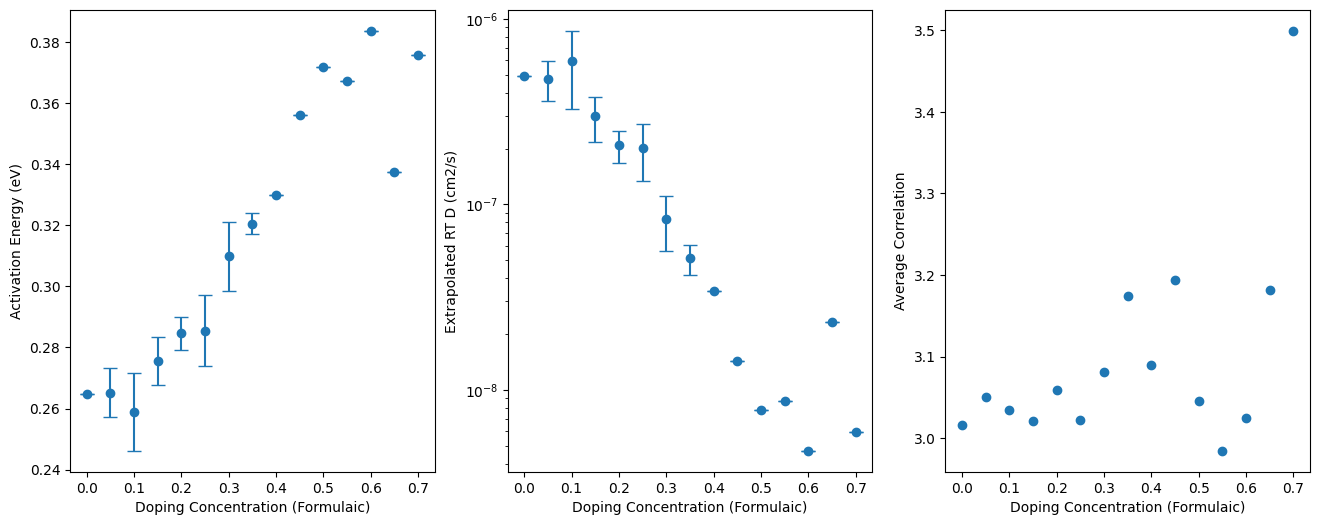

In [28]:
fig, axs = plt.subplots(1,3, figsize=(16,6))

groups = arrhenius_config_df.groupby(['Doping Element', 'Doping Concentration (Formulaic)']).groups
reduced_summary_columns = ['Doping Element', 'Doping Concentration (Formulaic)', 
           'Mean Activation Energy (eV)', 'STD Activation Energy (eV)',
           'Mean RT D (cm2/s)', 'STD RT D (cm2/s)', 'Average Correlation']
reduced_arrhenius = pd.DataFrame(columns=reduced_summary_columns)
for key in groups:
    group = groups[key]
    group_arrhenius = arrhenius_config_df.iloc[group].reset_index()

    D_ave = np.mean(group_arrhenius['RT D (cm2/s)'])
    D_std = np.std(group_arrhenius['RT D (cm2/s)'])
    Ea_ave = np.mean(group_arrhenius['Activation Energy (eV)'])
    Ea_std = np.std(group_arrhenius['Activation Energy (eV)'])
    corr = group_arrhenius['Average Correlation']

    entry = pd.DataFrame([[key[0], key[1], Ea_ave, Ea_std, D_ave, D_std, np.mean(corr)]], columns=reduced_summary_columns)
    reduced_arrhenius = pd.concat([reduced_arrhenius, entry], ignore_index=True)

display(reduced_arrhenius)

axs[0].errorbar(reduced_arrhenius['Doping Concentration (Formulaic)'], 
                reduced_arrhenius['Mean Activation Energy (eV)'], 
                yerr=reduced_arrhenius['STD Activation Energy (eV)'], fmt='o', capsize=5)

axs[1].errorbar(reduced_arrhenius['Doping Concentration (Formulaic)'], 
                reduced_arrhenius['Mean RT D (cm2/s)'], 
                yerr=reduced_arrhenius['STD RT D (cm2/s)'], fmt='o', capsize=5)

axs[2].scatter(reduced_arrhenius['Doping Concentration (Formulaic)'], 
               reduced_arrhenius['Average Correlation'])

axs[0].set_xlabel('Doping Concentration (Formulaic)')
axs[0].set_ylabel('Activation Energy (eV)')
axs[1].set_xlabel('Doping Concentration (Formulaic)')
axs[1].set_ylabel('Extrapolated RT D (cm2/s)')
axs[1].set_yscale('log')
axs[2].set_xlabel('Doping Concentration (Formulaic)')
axs[2].set_ylabel('Average Correlation')

plt.show()